# VQ-VAE decoder imoprovements with elev and clim inputs

This notebook improves the VQ-VAE decoder by adding a few more conv layers that takes elevation and climatology as inputs.

In [ ]:
import os
import sys
import time
import h5py
import numpy as np
from glob import glob

# ------------------------------------------------------- #
# Turn-off warnings
import logging
import warnings

warnings.filterwarnings("ignore")
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
logging.getLogger("tensorflow").setLevel(logging.ERROR)

# ------------------------------------------------------- #
# Turn-off tensoflow-specific warnings
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

tf.autograph.set_verbosity(0)
tf.get_logger().setLevel('ERROR')

# ------------------------------------------------------- #
# Import customized modules and settings
sys.path.insert(0, '/glade/u/home/ksha/GAN_proj/')
sys.path.insert(0, '/glade/u/home/ksha/GAN_proj/libs/')

from namelist import *
import data_utils as du
import model_utils as mu

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# from keras_unet_collection import models

## Hyperparameters

In [4]:
# ------------------------------------------------------- #
# Hyperparameters
input_size = (224, 464, 3)
filter_nums = [32, 64, 32]
# ============================= #

load_weights = False

# location of the previous weights
model_name_load = model_dir+'models/VAE_refine_base/'
# location for saving new weights
model_name_save = model_dir+'models/VAE_refine_base/'

# Training setups
epochs = 9999
batch_size = 64 #64
N_batch = 128
lrs = mu.cosine_schedule(N_batch, l_min=1e-5, l_max=1e-4)

## Validation set

In [5]:
with h5py.File(save_dir+'CCPA_domain.hdf', 'r') as h5io:
    land_mask_CCPA = h5io['land_mask_CCPA'][...]  
ocean_mask = land_mask_CCPA == 0.0
# ------------------------------------------------------- #
# Validation set
BATCH_dir = model_dir+'BATCH_dscale/'
filenames = sorted(glob(BATCH_dir+'*npy'))
filenames_valid_ = filenames[-1460:]
filenames_train_ = filenames[:-1460]

L_valid = 200
filenames_valid = filenames_valid_[::7][:L_valid] #[::10]

valid_X = np.empty((L_valid,)+input_size)
valid_Y = np.empty((L_valid,)+input_size[:-1]+(1,))

for i, name_ in enumerate(filenames_valid):
    temp_data = np.load(name_)
    valid_X[i, ...] = temp_data[..., :3]
    valid_Y[i, ...] = temp_data[..., 3:]

In [6]:
def valid_func(model, valid_X, valid_Y, ocean_mask):
    y_pred = model.predict(valid_X)[..., 0]
    y_pred[:, ocean_mask] = 0
    y_pred[y_pred<0] = 0
    return du.mean_absolute_error(to_precip(valid_Y[..., 0]), to_precip(y_pred))

def to_precip(x):
    x[x<0] = 0
    return 10*(np.exp(x) - 1)

In [7]:
# def base_func(valid_X, valid_Y, ocean_mask):
#     y_pred = valid_X[..., 0]
#     y_pred[:, ocean_mask] = 0
#     y_pred[y_pred<0] = 0
#     return du.mean_absolute_error(to_precip(valid_Y[..., 0]), to_precip(y_pred))

# base_func(valid_X, valid_Y, ocean_mask)

base_ref = 0.11056491707573876

In [8]:
filename_train = filenames_train_
L_train = len(filename_train)

min_del = 0.0
max_tol = 3 # early stopping with 2-epoch patience
tol = 0

In [1]:
# ------------------------------------------------------- #
# Training loop
strategy = tf.distribute.MirroredStrategy()
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

with strategy.scope():
    
    model = mu.VQ_VAE_refine_blocks(input_size, filter_nums)
    model.compile(loss=keras.losses.mean_absolute_error, 
                  optimizer=keras.optimizers.Adam(learning_rate=1e-4))
    
    # load weights
    if load_weights:
        W_old = mu.dummy_loader(model_name_load)
        model.set_weights(W_old)
        
    # ----------------------------------------------- #
    # Major training loop + training batch generation
    
    batch_X = np.empty((batch_size,)+input_size)
    batch_X[...] = np.nan
    batch_Y = np.empty((batch_size,)+input_size[:-1]+(1,))
    batch_Y[...] = np.nan
    
    for i in range(epochs):
        
        print('epoch = {}'.format(i))
        
        if i == 0:
            record = valid_func(model, valid_X, valid_Y, ocean_mask)
            print('Initial validation loss: {}'.format(record))
        
        start_time = time.time()
        for j in range(N_batch):

            tf.keras.backend.set_value(model.optimizer.learning_rate, lrs[j])
            
            inds_rnd = du.shuffle_ind(L_train)
            inds_ = inds_rnd[:batch_size]
            
            for k, ind in enumerate(inds_):
                # import batch data
                name_ = filename_train[ind]
                temp_data = np.load(name_)
                batch_X[k, ...] = temp_data[..., :3]
                batch_Y[k, ...] = temp_data[..., 3:]

            if np.sum(np.isnan(batch_X)) > 0:
                raise
                
            model.train_on_batch(batch_X, batch_Y)
            
        # on epoch-end
        record_temp = valid_func(model, valid_X, valid_Y, ocean_mask)
    
        if record - record_temp > min_del:
            print('Validation loss improved from {} to {}'.format(record, record_temp))
            record = record_temp
            print("Save to {}".format(model_name_save))
            model.save(model_name_save)
            
        else:
            print('Validation loss {} NOT improved'.format(record_temp))
        
        print("--- %s seconds ---" % (time.time() - start_time))
        # mannual callbacks

### Monitor the progress

In [9]:
model = models.unet_plus_2d(input_size, filter_num, n_labels=1,
                            stack_num_down=2, stack_num_up=2,
                            activation='GELU', output_activation=None, 
                            batch_norm=False, pool=False, unpool=True, 
                            deep_supervision=False, name='xnet')

model.compile(loss=keras.losses.mean_absolute_error, 
              optimizer=keras.optimizers.Adam(learning_rate=1e-4))

# load weights
if load_weights:
    W_old = mu.dummy_loader(model_name_load)
    model.set_weights(W_old)

In [25]:
y_pred = model.predict(valid_X)[..., 0]
y_pred[:, ocean_mask] = 0
y_pred[y_pred<0] = 0

7/7 [==============================] - 1s 138ms/step


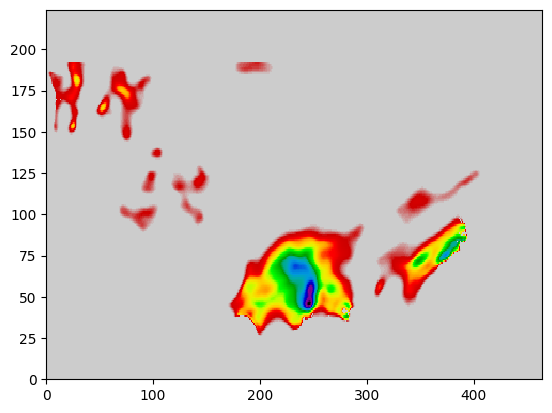

In [33]:
plt.pcolormesh(y_pred[0, ...], cmap=plt.cm.nipy_spectral_r)

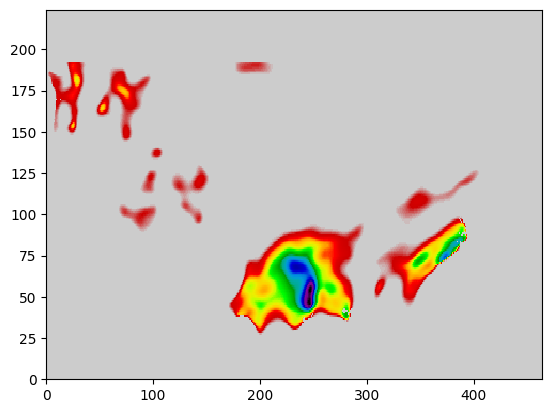

In [31]:
plt.pcolormesh(valid_X[0, ..., 0], cmap=plt.cm.nipy_spectral_r)